## Exploratory Data Analysis(EDA)  数据可视化分析

In [1]:
import numpy as np 
import pandas as pd

import pandas_profiling

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

/Users/huangshan/Documents/software/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
train=pd.read_csv('titanic/train.csv')
test=pd.read_csv('titanic/test.csv')

In [3]:
train.head(3)

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S

### 使用pandas-profiling进行直接分析

In [4]:
pandas_profiling.ProfileReport(train)
# 同理 还可以查看test.csv

## 数据预处理（数据清洗）

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


从上面的结果可以看出，每列数据的个数不同，这表明我们的数据中可能存在缺失值

### 缺失值处理

In [6]:
def missing_percentage(df):
    """
    以df作为输入 返回两列 一列是缺失值个数 一列是缺失值比例
    """
    total = df.isnull().sum().sort_values(ascending = False)
    percent = round(df.isnull().sum().sort_values(ascending = False)/len(df)*100,2)
    return pd.concat([total, percent], axis=1, keys=['Total','Percent'])

In [7]:
missing_percentage(train)

Total  Percent
Cabin          687    77.10
Age            177    19.87
Embarked         2     0.22
Fare             0     0.00
Ticket           0     0.00
Parch            0     0.00
SibSp            0     0.00
Sex              0     0.00
Name             0     0.00
Pclass           0     0.00
Survived         0     0.00
PassengerId      0     0.00

接下来对Cabin，Age和Embarked这三个特征分别进行缺失值的处理（填充）

#### Embarked缺失值处理

In [8]:
def percent_value_counts(df, feature):
    """
    df和特征名称作为输入，返回该特征中每种数值的个数及占比
    """
    percent = pd.DataFrame(round(df.loc[:,feature].value_counts(dropna=False, normalize=True)*100,2))
    ## creating a df with th
    total = pd.DataFrame(df.loc[:,feature].value_counts(dropna=False))
    ## concating percent and total dataframe

    total.columns = ["Total"]
    percent.columns = ['Percent']
    return pd.concat([total, percent], axis = 1)
    

In [9]:
percent_value_counts(train, 'Embarked')

Total  Percent
S      644    72.28
C      168    18.86
Q       77     8.64
NaN      2     0.22

In [10]:
# 可以看出在 Embarked这一特征中只有两个缺失值 进一步查看
train[train.Embarked.isnull()]

PassengerId  Survived  Pclass                                       Name  \
61            62         1       1                        Icard, Miss. Amelie   
829          830         1       1  Stone, Mrs. George Nelson (Martha Evelyn)   

        Sex   Age  SibSp  Parch  Ticket  Fare Cabin Embarked  
61   female  38.0      0      0  113572  80.0   B28      NaN  
829  female  62.0      0      0  113572  80.0   B28      NaN

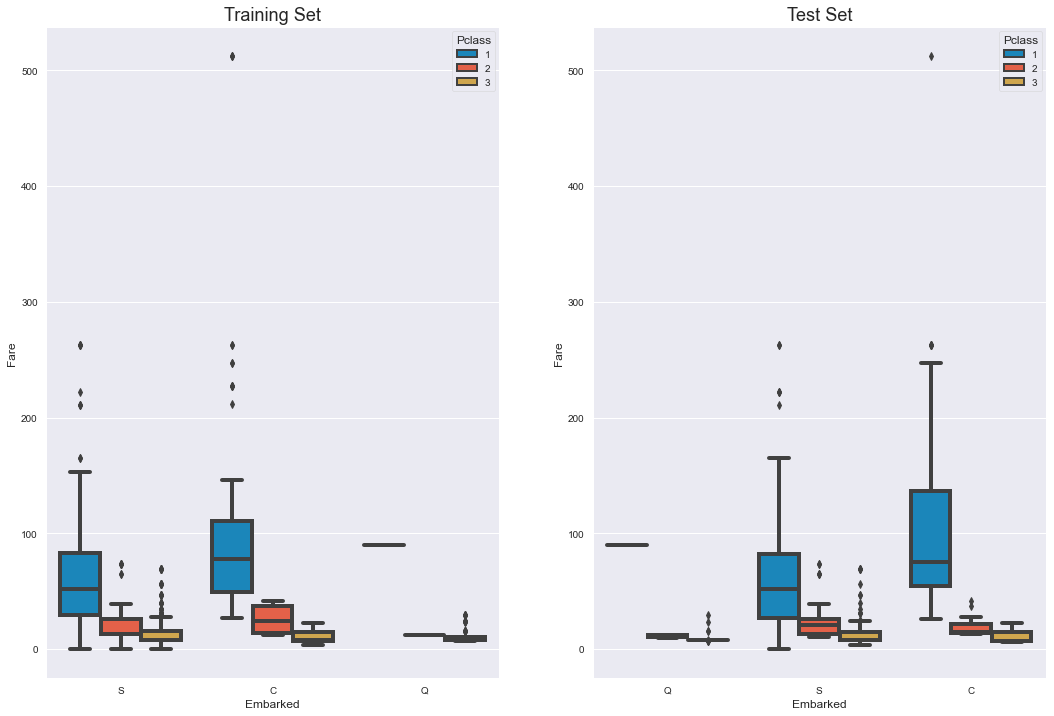

In [11]:
# 发现这两名乘客的票价均为80 为此进一步查看 上岸港口和船票等级的关系
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=(16,12),ncols=2)
ax1 = sns.boxplot(x="Embarked", y="Fare", hue="Pclass", data=train, ax = ax[0]);
ax2 = sns.boxplot(x="Embarked", y="Fare", hue="Pclass", data=test, ax = ax[1]);
ax1.set_title("Training Set", fontsize = 18)
ax2.set_title('Test Set',  fontsize = 18)
fig.show()

不难看出，不管是在测试集还是训练集中，在Fare=80的条件下，最接近传票等级Pclass=1，上传港口Embarked=C的情况，所以这两个缺失值使用C来填充

#### Carbin缺失值处理

In [12]:
# 首先查看缺失值比例
print("Train Cabin missing: " + str(train.Cabin.isnull().sum()/len(train.Cabin)))
print("Test Cabin missing: " + str(test.Cabin.isnull().sum()/len(test.Cabin)))

Train Cabin missing: 0.7710437710437711
Test Cabin missing: 0.7822966507177034


可以发现 缺失值比例很高，因此我们可以采取的方式有：

+ 直接放弃这个特征
+ 以合适的方式去使用这个特征，比如：可以假设 有carbin记录的乘客比其他没有的有着更高的社会地位，或者说 有Carbin记录的乘客更可能在逃生时优先考虑上船。


In [13]:
# 首先将 train和test合并，并把所有NAN置为N
survivers = train.Survived
train.drop(["Survived"],axis=1, inplace=True)
all_data = pd.concat([train,test], ignore_index=False)
all_data.Cabin.fillna("N", inplace=True)

In [14]:
# 观察Carbin的船舱数字可以发现：所有机舱名称均以英文字母开头，后跟多个数字。故而可以根据客舱名称的字母对这些客舱进行分组。
all_data.Cabin = [i[0] for i in all_data.Cabin]
percent_value_counts(all_data, "Cabin")

Total  Percent
N   1014    77.46
C     94     7.18
B     65     4.97
D     46     3.51
E     41     3.13
A     22     1.68
F     21     1.60
G      5     0.38
T      1     0.08

In [15]:
# 这里可以考虑使用其他特征来辅助我们进行 Cabin值的填充，比如，以字母分组的Cabin中 每组fare的平均值作为区间进行划分
all_data.groupby("Cabin")['Fare'].mean().sort_values()

Cabin
G     14.205000
F     18.079367
N     19.132707
T     35.500000
A     41.244314
D     53.007339
E     54.564634
C    107.926598
B    122.383078
Name: Fare, dtype: float64

In [16]:
def cabin_estimator(i):
    """Grouping cabin feature by the first letter"""
    a = 0
    if i<16:
        a = "G"
    elif i>=16 and i<27:
        a = "F"
    elif i>=27 and i<38:
        a = "T"
    elif i>=38 and i<47:
        a = "A"
    elif i>= 47 and i<53:
        a = "E"
    elif i>= 53 and i<54:
        a = "D"
    elif i>=54 and i<116:
        a = 'C'
    else:
        a = "B"
    return a

In [17]:
# 先把缺失的数据分出来 填充完之后 再划分成 train和test
with_N = all_data[all_data.Cabin == "N"]
without_N = all_data[all_data.Cabin != "N"]

# 使用cabin_estimator进行填充
with_N['Cabin'] = with_N.Fare.apply(lambda x: cabin_estimator(x))

#合并所有数据
all_data = pd.concat([with_N, without_N], axis=0)

#使用PassengerId进行train和test的划分
all_data.sort_values(by = 'PassengerId', inplace=True)
train = all_data[:891]
test = all_data[891:]

# 把drop掉的Survived列加回来
train['Survived'] = survivers

#### Fare缺失值处理

In [18]:
test[test.Fare.isnull()]

PassengerId  Pclass                Name   Sex   Age  SibSp  Parch Ticket  \
152         1044       3  Storey, Mr. Thomas  male  60.5      0      0   3701   

     Fare Cabin Embarked  
152   NaN     B        S

仔细观察可以知道，Fare只有测试集中有一个缺失值，虽然我们可以直接使用Fare的平均值对其进行填充，但是我们可以利用Pclass和Embarked这两个特征去进行一些推理

In [21]:
percent_value_counts(train, 'Fare') # 票价并没有固定的类别，比较随机

Total  Percent
8.0500      43     4.83
13.0000     42     4.71
7.8958      38     4.26
7.7500      34     3.82
26.0000     31     3.48
...        ...      ...
8.4583       1     0.11
9.8375       1     0.11
8.3625       1     0.11
14.1083      1     0.11
17.4000      1     0.11

[248 rows x 2 columns]

In [19]:
missing_value = test[(test.Pclass == 3) & 
                     (test.Embarked == "S") & 
                     (test.Sex == "male")].Fare.mean()
# 使用与这一缺失数据更接近的数据的平均值去进行填充
test.Fare.fillna(missing_value, inplace=True)

In [20]:
missing_value

12.718872

#### Age缺失值处理

In [22]:
print ("Train age missing value: " + str((train.Age.isnull().sum()/len(train))*100)+str("%"))
print ("Test age missing value: " + str((test.Age.isnull().sum()/len(test))*100)+str("%"))

Train age missing value: 19.865319865319865%
Test age missing value: 20.574162679425836%


直觉上而言，年龄Age这一特征对于存活是非常重要的特征，鉴于缺失率达到20%，使用平均数、众数、中位数这些统计特征去填充都是不合适的，故这一特征留在后面使用机器学习的方式来估算

## 可视化查看特征间关联

关于特征间的关联，可以进行一些合理的假设，比如：

+ 性别：存活的女性人数多于男性
+ Pclass：具有较高社会经济地位的乘客比其他人幸存下来更多。
+ 年龄：年轻的乘客比其他乘客幸存的时间更长。
+ 票价：票价较高的乘客比其他乘客幸存的时间更长。 这可以与Pclass相关联。


### Gender和survived

Text(0.5, 0, 'Sex')

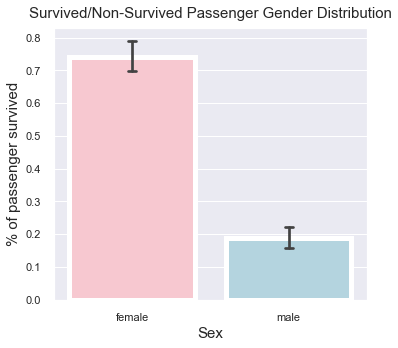

In [40]:
pal = {'male':"lightblue", 'female':"Pink"}
sns.set(style="darkgrid")
plt.subplots(figsize = (5,5))
ax = sns.barplot(x = "Sex", 
                 y = "Survived", 
                 data=train, 
                 palette = pal,
                 linewidth=5,
                 order = ['female','male'],
                 capsize = .05)
plt.title("Survived/Non-Survived Passenger Gender Distribution", fontsize = 15,loc = 'center', pad = 10)
plt.ylabel("% of passenger survived", fontsize = 15)
plt.xlabel("Sex",fontsize = 15)

上图展示了 幸存乘客中的男女比例，可以看出，约74％的女性乘客幸存下来，而只有约19％的男性乘客幸存下来。

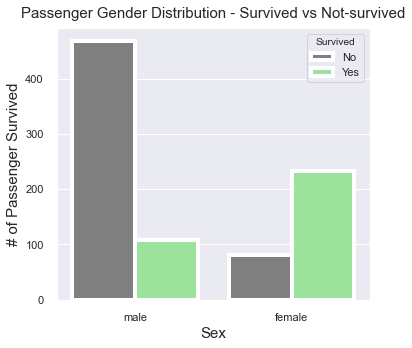

In [46]:
pal = {1:"lightgreen", 0:"gray"}
sns.set(style="darkgrid")
plt.subplots(figsize = (5,5))
ax = sns.countplot(x = "Sex", 
                   hue="Survived",
                   data = train, 
                   linewidth=4, 
                   palette = pal)

plt.title("Passenger Gender Distribution - Survived vs Not-survived", fontsize = 15, pad=10)
plt.xlabel("Sex", fontsize = 15);
plt.ylabel("# of Passenger Survived", fontsize = 15)

leg = ax.get_legend()
leg.set_title("Survived")
legs = leg.texts
legs[0].set_text("No")
legs[1].set_text("Yes")
plt.show()

上图分别展示了男性和女性幸存和未幸存的比例，可以看出，女性大部分都幸存了，而男性存活的比例大约占未存活的1/3

**结论**

与假设的一样，女性存活率高于男性，和日常生活中，让妇女和儿童先走的思想一致。

### Pclass和survived

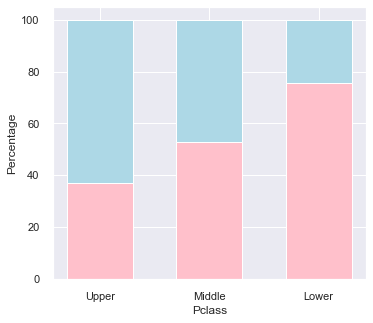

In [51]:
temp = train[['Pclass', 'Survived', 'PassengerId']].groupby(['Pclass', 'Survived']).count().reset_index()
temp_df = pd.pivot_table(temp, values = 'PassengerId', index = 'Pclass',columns = 'Survived')
names = ['No', 'Yes']
temp_df.columns = names
r = [0,1,2]
totals = [i+j for i, j in zip(temp_df['No'], temp_df['Yes'])]
No_s = [i / j * 100 for i,j in zip(temp_df['No'], totals)]
Yes_s = [i / j * 100 for i,j in zip(temp_df['Yes'], totals)]
## Plotting
plt.subplots(figsize = (5,5))
barWidth = 0.60
names = ('Upper', 'Middle', 'Lower')
plt.bar(r, No_s, color='pink', edgecolor='white', width=barWidth) #No表示没有幸存 下图的粉色
plt.bar(r, Yes_s, bottom=No_s, color='lightblue', edgecolor='white', width=barWidth)#Yes表示幸存 下图的蓝色
# Custom x axis
plt.xticks(r, names)
plt.xlabel("Pclass")
plt.ylabel('Percentage')
 
# Show graphic
plt.show()

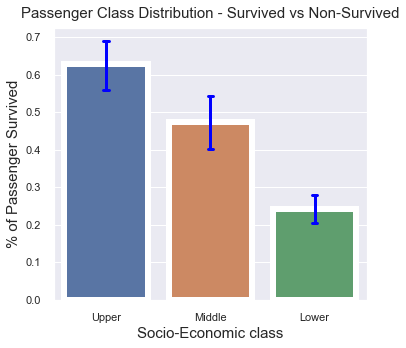

In [52]:
plt.subplots(figsize = (5,5))
sns.barplot(x = "Pclass", 
            y = "Survived", 
            data=train, 
            linewidth=6,
            capsize = .05,
            errcolor='blue',
            errwidth = 3)
plt.title("Passenger Class Distribution - Survived vs Non-Survived", fontsize = 15, pad=10)
plt.xlabel("Socio-Economic class", fontsize = 15);
plt.ylabel("% of Passenger Survived", fontsize = 15);
names = ['Upper', 'Middle', 'Lower']
val = [0,1,2] ## this is just a temporary trick to get the label right. 
plt.xticks(val, names);

不难发现，Pclass船票等级越高，幸存率越高

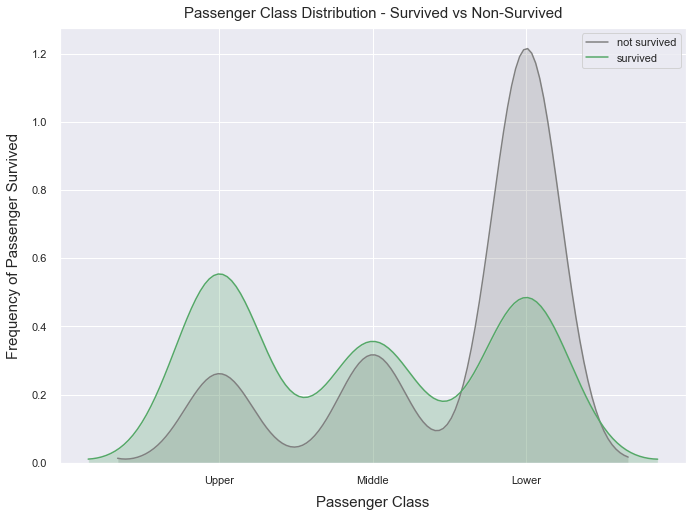

In [56]:
#  Kernel Density Plot
fig = plt.figure(figsize=(10,8),)
ax=sns.kdeplot(train.Pclass[train.Survived == 0] , 
               color='gray',
               shade=True,
               label='not survived')
ax=sns.kdeplot(train.loc[(train['Survived'] == 1),'Pclass'] , 
               color='g',
               shade=True, 
               label='survived', 
              )
plt.title('Passenger Class Distribution - Survived vs Non-Survived', fontsize = 15, pad = 10)
plt.ylabel("Frequency of Passenger Survived", fontsize = 15, labelpad = 10)
plt.xlabel("Passenger Class", fontsize = 15,labelpad =10)
## Converting xticks into words for better understanding
labels = ['Upper', 'Middle', 'Lower']
plt.xticks(sorted(train.Pclass.unique()), labels);

这里我们发现了一个问题，lower旅客的存活数量比Middle高，因为Lower乘客远远高于Middle和Upper。

**结论**

Pclass船票等级越高的人，越可能幸存

### Fare和survived

Text(0.5, 0, 'Fare')

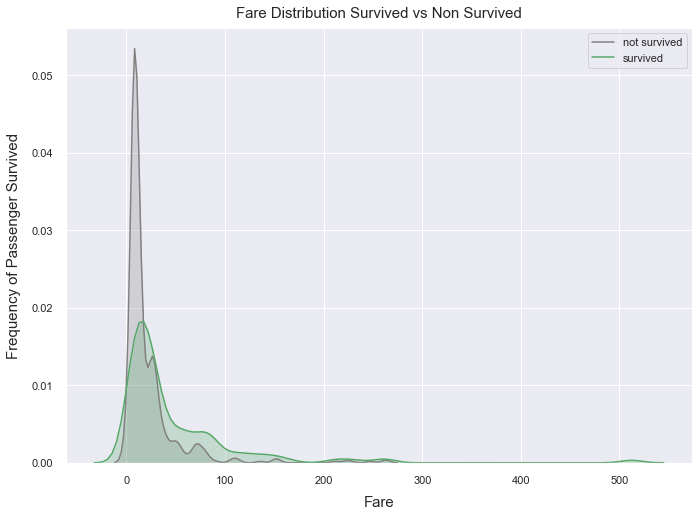

In [59]:
# Kernel Density Plot
fig = plt.figure(figsize=(10,8),)
ax=sns.kdeplot(train.loc[(train['Survived'] == 0),'Fare'] , color='gray',shade=True,label='not survived')
ax=sns.kdeplot(train.loc[(train['Survived'] == 1),'Fare'] , color='g',shade=True, label='survived')
plt.title('Fare Distribution Survived vs Non Survived', fontsize = 15, pad = 10)
plt.ylabel("Frequency of Passenger Survived", fontsize = 15, labelpad = 10)
plt.xlabel("Fare", fontsize = 15, labelpad = 10)

可以看出，大部分票价Fare在100美元以下的游客没有幸存，而Fare大于200的部分看起来似乎有些疑惑

In [64]:
train[train.Fare > 270] #这三个数据看起来像是 离群点

PassengerId  Pclass                                Name     Sex   Age  \
258          259       1                    Ward, Miss. Anna  female  35.0   
679          680       1  Cardeza, Mr. Thomas Drake Martinez    male  36.0   
737          738       1              Lesurer, Mr. Gustave J    male  35.0   

     SibSp  Parch    Ticket      Fare Cabin Embarked  Survived  
258      0      0  PC 17755  512.3292     B        C         1  
679      0      1  PC 17755  512.3292     B        C         1  
737      0      0  PC 17755  512.3292     B        C         1

### Age和survived

Text(0, 0.5, 'Frequency')

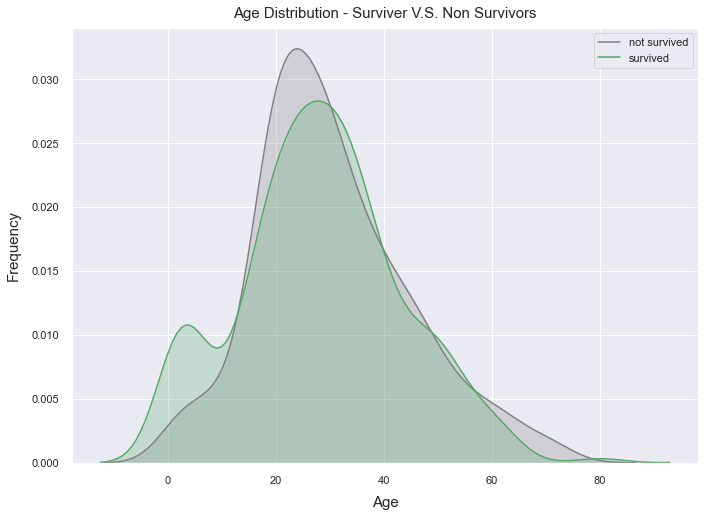

In [65]:
# Kernel Density Plot
fig = plt.figure(figsize=(10,8),)
ax=sns.kdeplot(train.loc[(train['Survived'] == 0),'Age'] , color='gray',shade=True,label='not survived')
ax=sns.kdeplot(train.loc[(train['Survived'] == 1),'Age'] , color='g',shade=True, label='survived')
plt.title('Age Distribution - Surviver V.S. Non Survivors', fontsize = 15, pad = 10)
plt.xlabel("Age", fontsize = 15, labelpad = 10)
plt.ylabel('Frequency', fontsize = 15, labelpad= 10)

除了最左边一部分存活比较明显，没有其他年龄特征的差别，这可能说明优先考虑儿童和婴儿

### 组合特征和survived

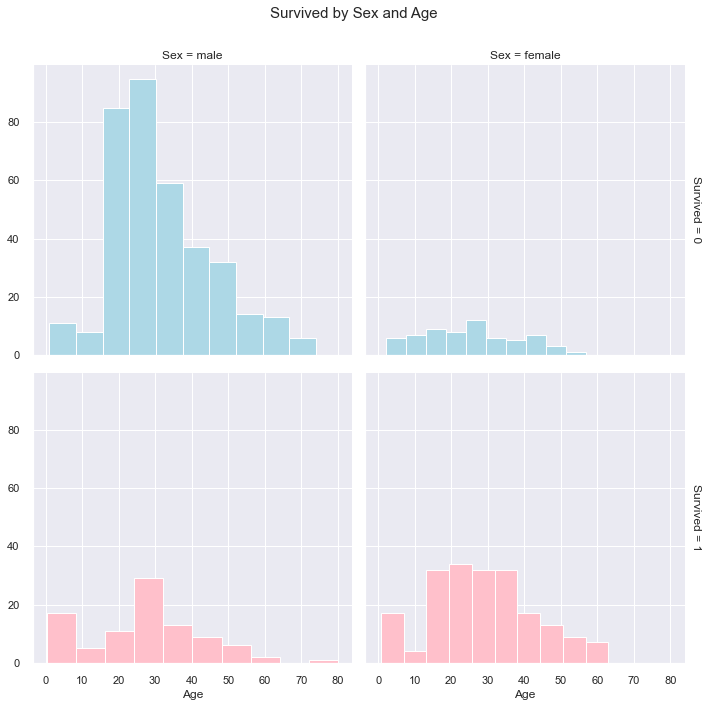

In [70]:
## 年龄 性别与幸存的关系
pal = {1:"pink", 0:"lightblue"}
g = sns.FacetGrid(train,size=5, col="Sex", row="Survived", margin_titles=True, hue = "Survived",
                  palette=pal)
g = g.map(plt.hist, "Age", edgecolor = 'white');
g.fig.suptitle("Survived by Sex and Age", size = 15)
plt.subplots_adjust(top=0.90)

Facetgrid是查看多变量之间关系的一种很好的方式

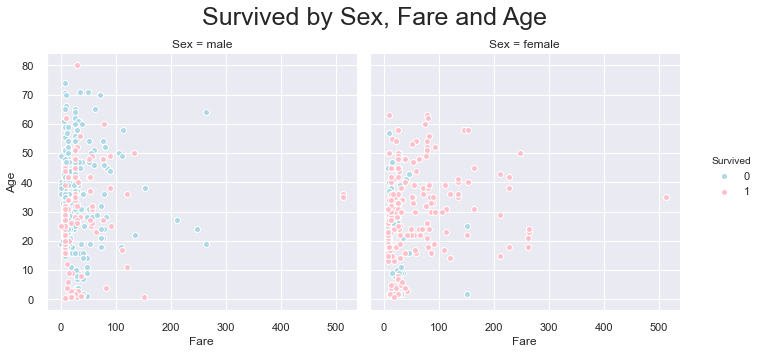

In [71]:
g = sns.FacetGrid(train, size=5,hue="Survived", col ="Sex", margin_titles=True,
                palette=pal,)
g.map(plt.scatter, "Fare", "Age",edgecolor="w").add_legend()
g.fig.suptitle("Survived by Sex, Fare and Age", size = 25)
plt.subplots_adjust(top=0.85)

由上图可知：

+ 上方的网格清楚地显示了票价超过500美元的三个离群值。 在这一点上，我认为我们很有信心应删除这些异常值。
+ 大部分乘客的票价在100美元左右。